# 05 - Retraining

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import time

import joblib
import json
import pickle

In [3]:
import sys
sys.path.append('../')

import src

In [4]:
plt.style.use('fivethirtyeight')
pd.set_option('precision', 4)

## Load model

In [5]:
with open('../deploy/columns.json') as fh:
    columns = json.load(fh)

with open('../deploy/dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

pipeline = joblib.load('../models/pipeline.pickle')

## Load database data

In [6]:
df_heroku = src.loader.load_heroku_csv(columns, dtypes)

In [7]:
df_heroku.head(2)

,type,date,operation,lat,long,sex,age,ethnicity_officer,legislation,search_target,station,predicted_outcome,success
observation_id,,,,,,,,,,,,,
cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,Person search,2020-01-01 01:45:00+00:00,False,NaN,NaN,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire,True,False
3601e51b-f40a-4466-b884-d9284497462c,Person search,2020-01-01 02:53:14+00:00,NaN,NaN,NaN,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,city-of-london,True,False


In [8]:
df_heroku.shape

(3999, 13)

In [9]:
df_customer =  pd.read_csv('../data/X_test_1.csv')\
                    .set_index('observation_id')\
                    .drop(columns=['Self-defined ethnicity'])
df_customer.columns = columns
df_customer = df_customer.astype(dtypes)
df_customer['predicted_outcome'] = src.evaluate.authorise_search(pipeline, df_customer)
df_customer = df_customer.join(pd.read_csv('../data/y_test_1.csv')\
                                  .set_index('observation_id')\
                                  .rename(columns={'0': 'success'}))

In [10]:
df_customer.head(2)

,type,date,operation,lat,long,sex,age,ethnicity_officer,legislation,search_target,station,predicted_outcome,success
observation_id,,,,,,,,,,,,,
3d931c84-94d3-4a14-869c-b10fef26e9ad,Person search,2020-01-01 00:56:00+00:00,False,NaN,NaN,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,True,False
cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,Person search,2020-01-01 01:45:00+00:00,False,NaN,NaN,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire,True,False


## Analysis

### Data Profile

In [11]:
profile = pp.ProfileReport(df_customer, title='Live Data Profiling Report', explorative=False, minimal=False, pool_size=0, progress_bar=True)
profile.to_file('../reports/profiling/live_profile.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/pandas_profiling/model/correlations.py:139: UserWarning: There was an attempt to calculate the phi_k correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"phi_k": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  (include the error message: '{error}')"""


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Analyse Results

In [11]:
from sklearn.metrics import precision_score, confusion_matrix

In [12]:
df_train_labels = pd.read_pickle('../data/labelled_train')

#### Pipeline performance on Test 1

In [16]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum difference in precision between ethnicity-gender-subgroups within stations',
                                 'Maximum difference in precision between stations',
                                 'Maximum difference in precision between ethnicity-gender-subgroups'],
                          columns=pd.MultiIndex.from_arrays([['Test set 1']*2+['Training data']*2+[''], ['Model', 'Benchmark','Model', 'Benchmark', 'Target']]))

# pipeline
include = df_customer['success'].notna()
authorised = df_customer.loc[include, 'predicted_outcome'].astype(bool)
success = df_customer.loc[include, 'success'].astype(bool)
X = df_customer.loc[include, columns]
df_results.iat[0, 0] = precision_score(success, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, success, X).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, success, X)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, success, X)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(success, np.ones(success.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(success.shape), success, X).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(success.shape), success, X)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(success.shape), success, X)

# training data
success = df_train_labels['success']
authorised = df_train_labels['authorised']
X = df_train_labels[columns]
df_results.iat[0, 2] = precision_score(success, authorised)
df_results.iat[1, 2] = src.evaluate.within_station_discrepancy(authorised, success, X).max()
df_results.iat[2, 2] = src.evaluate.across_station_discrepancy(authorised, success, X)
df_results.iat[3, 2] = src.evaluate.across_subgroup_discrepancy(authorised, success, X)
df_results.iat[0, 3] = precision_score(success, np.ones(success.shape))
df_results.iat[1, 3] = src.evaluate.within_station_discrepancy(np.ones(success.shape), success, X).max()
df_results.iat[2, 3] = src.evaluate.across_station_discrepancy(np.ones(success.shape), success, X)
df_results.iat[3, 3] = src.evaluate.across_subgroup_discrepancy(np.ones(success.shape), success, X)

# targets
df_results.iat[0, 4] = '-'
df_results.iat[1, 4] = 0.05
df_results.iat[2, 4] = 0.1
df_results.iat[3, 4] = 0.05

df_results.round(3)

Test set 1            \
                                                        Model Benchmark   
Search precision                                       0.2915    0.2782   
Maximum difference in precision between ethnici...      0.117    0.1123   
Maximum difference in precision between stations       0.3573     0.397   
Maximum difference in precision between ethnici...      0.113    0.1152   

                                                   Training data            \
                                                           Model Benchmark   
Search precision                                            0.24    0.2014   
Maximum difference in precision between ethnici...        0.2913      0.24   
Maximum difference in precision between stations          0.1988    0.3602   
Maximum difference in precision between ethnici...       0.05109   0.04013   

                                                           
                                                   Target  
Search precision                                        -  
Maximum difference in precision between ethnici...   0.05  
Maximum difference in precision between stations      0.1  
Maximum difference in precision between ethnici...   0.05

In [42]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum difference in precision between ethnicity-gender-subgroups within stations',
                                 'Maximum difference in precision between stations',
                                 'Maximum difference in precision between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
include = df_customer['success'].notna()
authorised = df_customer.loc[include, 'predicted_outcome'].astype(bool)
success = df_customer.loc[include, 'success'].astype(bool)
X = df_customer.loc[include, columns]
df_results.iat[0, 0] = precision_score(success, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, success, X).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, success, X)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, success, X)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(success, np.ones(success.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(success.shape), success, X).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(success.shape), success, X)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(success.shape), success, X)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2915,0.2782,-
Maximum difference in precision between ethnicity-gender-subgroups within stations,0.117,0.1123,0.05
Maximum difference in precision between stations,0.3573,0.397,0.1
Maximum difference in precision between ethnicity-gender-subgroups,0.113,0.1152,0.05


In [14]:
pd.DataFrame(confusion_matrix(success, authorised),
             index=pd.MultiIndex.from_product([['True outcome'], ['no succes', 'success']]),
             columns=pd.MultiIndex.from_product([['Predicted outcome'], ['no succes', 'success']]),
            )

Predicted outcome        
                               no succes success
True outcome no succes               242    2645
             success                  25    1088

##### Fairness

In [20]:
df_subgroups = src.evaluate.calculate_subgroup_precisions(authorised, success, X, grouping=['ethnicity', 'gender'])\
                    .unstack()
df_subgroups.columns = pd.MultiIndex.from_product([['Model'], df_subgroups.columns])

_ = src.evaluate.calculate_subgroup_precisions(np.ones(success.shape), success, X, grouping=['ethnicity', 'gender'])\
                       .unstack()
_.columns = pd.MultiIndex.from_product([['Benchmark'], _.columns])

df_subgroups = df_subgroups.merge(_, left_index=True, right_on='ethnicity')\
                           .replace(np.nan, '-')
df_subgroups

Benchmark   Model
ethnicity gender                  
Asian     Female         -       -
          Male      0.2114  0.2202
Black     Female         -       -
          Male      0.2408  0.2461
Mixed     Female         -       -
          Male      0.1988  0.2148
Other     Female         -       -
          Male      0.2299  0.2317
White     Female     0.314  0.3152
          Male      0.3093  0.3278

In [26]:
success2 = df_train_labels['success']
authorised2 = df_train_labels['authorised']
X2 = df_train_labels[columns]
df_subgroups2 = src.evaluate.calculate_subgroup_precisions(authorised2, success2, X2, grouping=['ethnicity', 'gender'])\
                    .unstack()
df_subgroups2.columns = pd.MultiIndex.from_product([['Model'], df_subgroups2.columns])

_ = src.evaluate.calculate_subgroup_precisions(np.ones(success2.shape), success2, X2, grouping=['ethnicity', 'gender'])\
                       .unstack()
_.columns = pd.MultiIndex.from_product([['Benchmark'], _.columns])

df_subgroups2 = df_subgroups2.merge(_, left_index=True, right_on='ethnicity')\
                           .replace(np.nan, '-')
df_comb = df_subgroups.stack().merge(df_subgroups2.stack(), left_index=True, right_on=['ethnicity', 'gender'])
df_comb.columns = pd.MultiIndex.from_product([['Test set 1', 'Training data'], ['Benchmark', 'Model']])
df_comb

Test set 1         Training data        
                  Benchmark   Model     Benchmark   Model
ethnicity gender                                         
Asian     Female          -       -        0.1936  0.2249
          Male       0.2114  0.2202        0.2006  0.2417
Black     Female          -       -        0.1991  0.2240
          Male       0.2408  0.2461        0.2076  0.2468
Mixed     Female          -       -        0.1864  0.2042
          Male       0.1988  0.2148        0.2119  0.2530
Other     Female          -       -        0.2194  0.2553
          Male       0.2299  0.2317        0.2126  0.2535
White     Female      0.314  0.3152        0.1793  0.2057
          Male       0.3093  0.3278        0.2031  0.2434

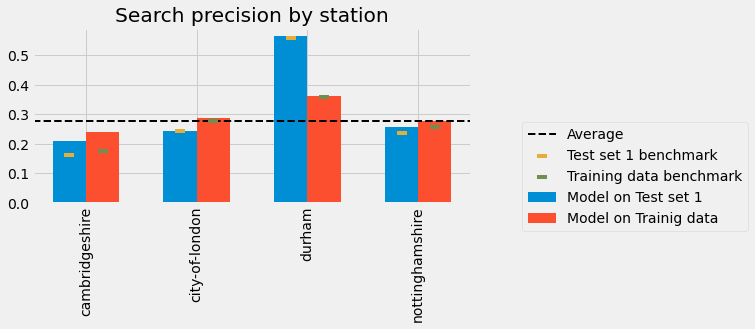

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))

station_precisions = src.evaluate.calculate_subgroup_precisions(authorised, success, X, grouping=['station']).dropna()
station_precisions2 = src.evaluate.calculate_subgroup_precisions(authorised2, success2, X2, grouping=['station']).dropna()
station_precisions2 = station_precisions2[station_precisions2.index.isin(station_precisions.index)]
ax.set_title('Search precision by station')

#bars
ax.bar(x=np.arange(0, len(station_precisions), 1)-0.15, height=station_precisions, label='Model on Test set 1', width=0.3)
ax.bar(x=np.arange(0, len(station_precisions2), 1)+0.15, height=station_precisions2, label='Model on Trainig data', width=0.3)

# benchmarks
ax.scatter(x=np.arange(0, len(station_precisions), 1)-0.15, y=src.evaluate.calculate_subgroup_precisions(np.ones(success.shape), success, X, grouping=['station']).dropna(), zorder=10, label='Test set 1 benchmark', marker='_', s=100)
ax.scatter(x=np.arange(0, len(station_precisions2), 1)+0.15, y=src.evaluate.calculate_subgroup_precisions(np.ones(success2.shape), success2, X2, grouping=['station'])[station_precisions.index].dropna(), zorder=10, label='Training data benchmark', marker='_', s=100)

ax.axhline(precision_score(success, np.ones(success.shape)), linewidth=2, linestyle='--', c='k', label='Average')
ax.set_xticks(np.arange(0, len(station_precisions), 1))
ax.set_xticklabels(station_precisions.index, rotation=90)
ax.legend(bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

fig.savefig('../reports/figures/live_stations_precision.jpg', dpi=300, bbox_inches='tight')

##### Classification report

In [63]:
from sklearn.metrics import classification_report

In [66]:
pd.DataFrame(classification_report(success, authorised, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.9064,0.2915,0.3325,0.5989,0.7353
recall,0.0838,0.9775,0.3325,0.5307,0.3325
f1-score,0.1535,0.4490,0.3325,0.3012,0.2357
support,2887.0000,1113.0000,0.3325,4000.0000,4000.0000


## Improve Model
First, we reduce bias by explicitly correcting for group means.
(replace src.evaluate.authorise_search function)

Then, add ethnicity feature to pipeline.

Finally, retrain with full dataset, overweighting recent observations.

### Prepare re-training data

In [32]:
df = pd.read_pickle('../data/training.pickle')

In [33]:
df.head(1)

,type,date,operation,lat,long,sex,age,ethnicity_self,ethnicity_officer,legislation,search_target,outcome,found_target,stripped,station,offense,success
observation_id,,,,,,,,,,,,,,,,,
d62c9e35-6293-45fc-aab6-706bdac1601e,Person search,2017-12-01 00:00:00+00:00,False,50.9234,-0.4611,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,False,False,sussex,True,False


In [34]:
# Drop metropolitan station from dataset
df = df[df.station!='metropolitan']

df = df[columns + ['success']]
for i in range(1):
    # oversample recent data
    df = df.append(df_customer[columns + ['success']])
    
    # oversample minorities
    df = df.append(df[df.ethnicity_officer!='White'])
    
df.shape

(379976, 12)

#### Select relevant columns

Requests will have the following format:
```
["observation_id": <string>,
 "Type": <string>,
 "Date": <string>,
 "Part of a policing operation": <boolean>,
 "Latitude": <float>,
 "Longitude": <float>,
 "Gender": <string>,
 "Age range": <string>,
 "Officer-defined ethnicity": <string>,
 "Legislation": <string>,
 "Object of search": <string>,
 "station": <string>]
 '''


In [35]:
supplied_columns = ['type', 'date', 'operation', 'lat', 'long', 'sex', 'age', 'ethnicity_officer', 'legislation', 'search_target', 'station']

In [46]:
X = df[supplied_columns]
y = df.success.values

### Adapt pipeline

In [37]:
from sklearn.preprocessing import OneHotEncoder

In [38]:
categoricals = ['type', 'sex', 'age', 'search_target', 'station', 'ethnicity_officer']
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
pipeline['preprocess'].transformer_list[0][1].transformers[2] = ('cat_encoder', oh_encoder, categoricals)

#### Train-Validation Split

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=X[['station']], shuffle=True)

#### Fit

In [41]:
%%time
pipeline_ = pipeline.fit(X, y)

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 14.6 s, sys: 8.48 s, total: 23.1 s
Wall time: 31.8 s


## Evaluation

#### Retrained pipeline in sample

In [48]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum difference in precision between ethnicity-gender-subgroups within stations',
                                 'Maximum difference in precision between stations',
                                 'Maximum difference in precision between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
authorised = src.evaluate.authorise_search(pipeline_, X, bias_correction=True).astype(bool)

df_results.iat[0, 0] = precision_score(y, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, y, X).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, y, X)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, y, X)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(y, np.ones(y.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(y.shape), y, X).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(y.shape), y, X)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(y.shape), y, X)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2329,0.2029,-
Maximum difference in precision between ethnicity-gender-subgroups within stations,0.4152,0.4174,0.05
Maximum difference in precision between stations,0.394,0.392,0.1
Maximum difference in precision between ethnicity-gender-subgroups,0.05598,0.03942,0.05


In [49]:
pd.DataFrame(confusion_matrix(y, authorised),
             index=pd.MultiIndex.from_product([['True outcome'], ['no succes', 'success']]),
             columns=pd.MultiIndex.from_product([['Predicted outcome'], ['no succes', 'success']]),
            )

Predicted outcome        
                               no succes success
True outcome no succes             59960  242915
             success                3347   73754

##### Fairness

In [51]:
df_subgroups = src.evaluate.calculate_subgroup_precisions(authorised, y, X, grouping=['ethnicity', 'gender'])\
                    .unstack()
df_subgroups.columns = pd.MultiIndex.from_product([['Model'], df_subgroups.columns])

_ = src.evaluate.calculate_subgroup_precisions(np.ones(y.shape), y, X, grouping=['ethnicity', 'gender'])\
                       .unstack()
_.columns = pd.MultiIndex.from_product([['Benchmark'], _.columns])

df_subgroups = df_subgroups.merge(_, left_index=True, right_on='ethnicity')\
                           .replace(np.nan, '-')
df_subgroups

Model         Benchmark        
gender     Female    Male    Female    Male
ethnicity                                  
Asian      0.2088  0.2320    0.1911  0.2009
Black      0.2113  0.2353    0.1977  0.2082
Mixed      0.1977  0.2384    0.1875  0.2107
Other      0.2537  0.2430    0.2199  0.2129
White      0.2002  0.2369    0.1805  0.2042

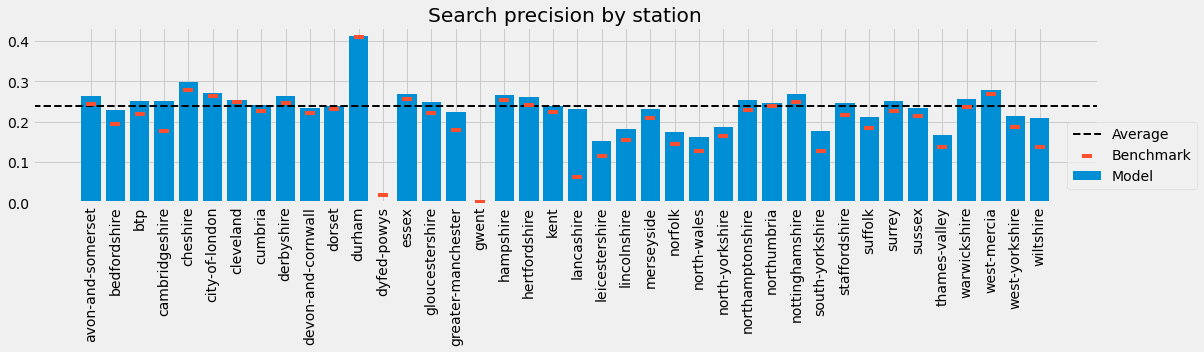

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(17,3))

station_precisions = src.evaluate.calculate_subgroup_precisions(authorised, y, X, grouping=['station']).dropna()
ax.set_title('Search precision by station')
ax.bar(x=np.arange(0, len(station_precisions), 1), height=station_precisions, label='Model')
ax.scatter(x=np.arange(0, len(station_precisions), 1), y=src.evaluate.calculate_subgroup_precisions(np.ones(y.shape), y, X, grouping=['station'])[station_precisions.index], zorder=10, label='Benchmark', marker='_', s=100)
ax.axhline(precision_score(y, authorised), linewidth=2, linestyle='--', c='k', label='Average')
ax.set_xticks(np.arange(0, len(station_precisions), 1))
ax.set_xticklabels(station_precisions.index, rotation=90)
ax.legend(bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.show()

fig.savefig('../reports/figures/stations_precision_retrain.jpg', dpi=300, bbox_inches='tight')

In [ ]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum difference in precision between ethnicity-gender-subgroups within stations',
                                 'Maximum difference in precision between stations',
                                 'Maximum difference in precision between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
authorised = src.evaluate.authorise_search(pipeline_, X_train, bias_correction=True).astype(bool)

df_results.iat[0, 0] = precision_score(y_train, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, y_train, X_train).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, y_train, X_train)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, y_train, X_train)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(y_train, np.ones(y_train.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(y_train.shape), y_train, X_train).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(y_train.shape), y_train, X_train)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(y_train.shape), y_train, X_train)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

In [36]:
# set up
df_results = pd.DataFrame(index=['Search precision',
                                 'Maximum difference in precision between ethnicity-gender-subgroups within stations',
                                 'Maximum difference in precision between stations',
                                 'Maximum difference in precision between ethnicity-gender-subgroups'],
                          columns=['Model', 'Benchmark', 'Target'])

# pipeline
authorised = src.evaluate.authorise_search(pipeline_, X_val, bias_correction=True).astype(bool)

df_results.iat[0, 0] = precision_score(y_val, authorised)
df_results.iat[1, 0] = src.evaluate.within_station_discrepancy(authorised, y_val, X_val).max()
df_results.iat[2, 0] = src.evaluate.across_station_discrepancy(authorised, y_val, X_val)
df_results.iat[3, 0] = src.evaluate.across_subgroup_discrepancy(authorised, y_val, X_val)

# evaluate benchmark
df_results.iat[0, 1] = precision_score(y_val, np.ones(y_val.shape))
df_results.iat[1, 1] = src.evaluate.within_station_discrepancy(np.ones(y_val.shape), y_val, X_val).max()
df_results.iat[2, 1] = src.evaluate.across_station_discrepancy(np.ones(y_val.shape), y_val, X_val)
df_results.iat[3, 1] = src.evaluate.across_subgroup_discrepancy(np.ones(y_val.shape), y_val, X_val)

# targets
df_results.iat[0, 2] = '-'
df_results.iat[1, 2] = 0.05
df_results.iat[2, 2] = 0.1
df_results.iat[3, 2] = 0.05

df_results

,Model,Benchmark,Target
Search precision,0.2389,0.2023,-
Maximum discrimination within station between ethnicity-gender-subgroup,0.2343,0.2434,0.05
Maximum precision discrepancy between stations overall,0.243,0.3995,0.1
Maximum discrimination between ethnicity-gender-subgroups,0.1183,0.09418,0.05


### Serialise

In [52]:
# serialise
joblib.dump(pipeline_, '../deploy/pipeline.pickle')
joblib.dump(pipeline_, '../models/pipeline_retrained.pickle')

['../models/pipeline_retrained.pickle']